Imports

In [1]:
import os
import zlib
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer
from kmodes.kprototypes import KPrototypes
from sqlalchemy import create_engine

SEED = 1111
np.random.seed(SEED)

In [2]:
def prepare_data_for_clustering(data, exclude=[]):
    #drop columns from exclude's variable
    if exclude != []:
        data = data.drop(columns=exclude)

    #transform categorical data into a binary format
    if 'game_modes' not in exclude:
        mlb_game_modes = MultiLabelBinarizer()
        transformed_mlb_game_modes = mlb_game_modes.fit_transform(data['game_modes'])
        data = pd.concat([data, pd.DataFrame(transformed_mlb_game_modes, columns=mlb_game_modes.classes_, index=data.index)], axis=1)
        data = data.drop(columns=['game_modes'])
    
    if 'genres' not in exclude:
        mlb_genres = MultiLabelBinarizer()
        transformed_mlb_genres = mlb_genres.fit_transform(data['genres'])
        data = pd.concat([data, pd.DataFrame(transformed_mlb_genres, columns=mlb_genres.classes_, index=data.index)], axis=1)
        data = data.drop(columns=['genres'])
    
    if 'platforms' not in exclude:
        mlb_platforms = MultiLabelBinarizer()
        transformed_mlb_platforms = mlb_platforms.fit_transform(data['platforms'])
        data = pd.concat([data, pd.DataFrame(transformed_mlb_platforms, columns=mlb_platforms.classes_, index=data.index)], axis=1)
        data = data.drop(columns=['platforms'])

    if 'themes' not in exclude:
        mlb_themes = MultiLabelBinarizer()
        transformed_mlb_themes = mlb_themes.fit_transform(data['themes'])
        data = pd.concat([data, pd.DataFrame(transformed_mlb_themes, columns=mlb_themes.classes_, index=data.index)], axis=1)
        data = data.drop(columns=['themes'])

    return data

In [3]:
def statistics_clusters(data):
    #show values from each feature
    game_modes_count = pd.Series(np.concatenate(data['game_modes']))
    display(game_modes_count.value_counts())

    genres_count = pd.Series(np.concatenate(data['genres']))
    display(genres_count.value_counts())

    platforms_count = pd.Series(np.concatenate(data['platforms']))
    display(platforms_count.value_counts())

    themes_count = pd.Series(np.concatenate(data['themes']))
    display(themes_count.value_counts())

    display(data['year_of_release'].value_counts())

Reading data

In [4]:
games_data_original = pd.read_json('../Databases/games.json')
games_data_original

,id,cover,first_release_date,game_modes,genres,name,platforms,themes,total_rating
0,1,291911.0,9.535968e+08,[1],"[5, 13, 31]",Thief II: The Metal Age,[6],"[1, 17, 23]",88.149403
1,2,96746.0,9.123840e+08,[1],"[13, 31]",Thief: The Dark Project,[6],"[1, 17, 23]",78.289619
2,3,129190.0,1.085443e+09,[1],"[5, 13, 31]",Thief: Deadly Shadows,"[6, 11]","[1, 17, 23]",82.503065
3,4,96744.0,1.393286e+09,[1],"[5, 31]",Thief,"[6, 9, 12, 14, 48, 49]","[1, 23, 33]",66.948249
4,5,93899.0,9.141984e+08,"[1, 3]",[12],Baldur's Gate,"[3, 6, 14, 39]","[17, 38]",86.002845
...,...,...,...,...,...,...,...,...,...
236537,298477,378217.0,NaN,NaN,"[12, 13]",Fantasy Quest: Errandsaga,NaN,[1],NaN
236538,298478,378219.0,NaN,NaN,"[31, 32]",Forest of Fear,NaN,[1],NaN
236539,298479,378221.0,NaN,NaN,"[31, 32]",Ghost Moon High Noon,NaN,[1],NaN
236540,298480,378220.0,NaN,NaN,"[13, 15, 32]",Harlot's Diary,NaN,NaN,NaN


In [5]:
game_modes_data = pd.read_json('../Databases/game_modes.json')

game_modes_dict = {}
for index, row in game_modes_data.iterrows():
    game_modes_dict[row['id']] = row['slug']

game_modes_dict

{1: 'single-player',
 2: 'multiplayer',
 3: 'co-operative',
 4: 'split-screen',
 5: 'massively-multiplayer-online-mmo',
 6: 'battle-royale'}

In [6]:
genres_data = pd.read_json('../Databases/genres.json')

genres_dict = {}
for index, row in genres_data.iterrows():
    genres_dict[row['id']] = row['slug']

genres_dict

{2: 'point-and-click',
 4: 'fighting',
 5: 'shooter',
 7: 'music',
 8: 'platform',
 9: 'puzzle',
 10: 'racing',
 11: 'real-time-strategy-rts',
 12: 'role-playing-rpg',
 13: 'simulator',
 14: 'sport',
 15: 'strategy',
 16: 'turn-based-strategy-tbs',
 24: 'tactical',
 25: 'hack-and-slash-beat-em-up',
 26: 'quiz-trivia',
 30: 'pinball',
 31: 'adventure',
 32: 'indie',
 33: 'arcade',
 34: 'visual-novel',
 35: 'card-and-board-game',
 36: 'moba'}

In [7]:
themes_data = pd.read_json('../Databases/themes.json')

themes_dict = {}
for index, row in themes_data.iterrows():
    themes_dict[row['id']] = row['slug']

themes_dict

{1: 'action',
 17: 'fantasy',
 18: 'science-fiction',
 19: 'horror',
 20: 'thriller',
 21: 'survival',
 22: 'historical',
 23: 'stealth',
 27: 'comedy',
 28: 'business',
 31: 'drama',
 32: 'non-fiction',
 33: 'sandbox',
 34: 'educational',
 35: 'kids',
 38: 'open-world',
 39: 'warfare',
 40: 'party',
 41: '4x-explore-expand-exploit-and-exterminate',
 42: 'erotic',
 43: 'mystery',
 44: 'romance'}

In [8]:
platforms_data = pd.read_json('../Databases/platforms.json')

platforms_dict = {}
for index, row in platforms_data.iterrows():
    platforms_dict[row['id']] = row['slug']

platforms_dict

{3: 'linux',
 4: 'n64',
 5: 'wii',
 6: 'win',
 7: 'ps',
 8: 'ps2',
 9: 'ps3',
 11: 'xbox',
 12: 'xbox360',
 13: 'dos',
 14: 'mac',
 15: 'c64',
 16: 'amiga',
 18: 'nes',
 19: 'snes',
 20: 'nds',
 21: 'ngc',
 22: 'gbc',
 23: 'dc',
 24: 'gba',
 25: 'acpc',
 26: 'zxs',
 27: 'msx',
 29: 'genesis-slash-megadrive',
 30: 'sega32',
 32: 'saturn',
 33: 'gb',
 34: 'android',
 35: 'gamegear',
 37: '3ds',
 38: 'psp',
 39: 'ios',
 41: 'wiiu',
 42: 'ngage',
 44: 'zod',
 46: 'psvita',
 47: 'vc',
 48: 'ps4--1',
 49: 'xboxone',
 50: '3do',
 51: 'fds',
 52: 'arcade',
 53: 'msx2',
 55: 'mobile',
 57: 'wonderswan',
 58: 'sfam',
 59: 'atari2600',
 60: 'atari7800',
 61: 'lynx',
 62: 'jaguar',
 63: 'atari-st',
 64: 'sms',
 65: 'atari8bit',
 66: 'atari5200',
 67: 'intellivision',
 68: 'colecovision',
 69: 'bbcmicro',
 70: 'vectrex',
 71: 'vic-20',
 72: 'ouya',
 73: 'blackberry',
 74: 'winphone',
 75: 'appleii',
 77: 'x1',
 78: 'segacd',
 79: 'neogeomvs',
 80: 'neogeoaes',
 82: 'browser',
 84: 'sg1000',
 85: 'd

In [9]:
cover_data = pd.read_json('../Databases/covers.json')
cover_data = cover_data.dropna(subset=['url'])
cover_data = cover_data.drop(columns=['game', 'height', 'width', 'alpha_channel', 'animated', 'game_localization'])
cover_data = cover_data.reset_index(drop=True)
cover_data = cover_data.rename({'id': 'cover'}, axis='columns')
cover_data['url'] = cover_data['url'].str.replace('t_thumb','t_cover_big')
cover_data

,cover,url
0,109,//images.igdb.com/igdb/image/upload/t_cover_bi...
1,243,//images.igdb.com/igdb/image/upload/t_cover_bi...
2,249,//images.igdb.com/igdb/image/upload/t_cover_bi...
3,250,//images.igdb.com/igdb/image/upload/t_cover_bi...
4,252,//images.igdb.com/igdb/image/upload/t_cover_bi...
...,...,...
214369,378287,//images.igdb.com/igdb/image/upload/t_cover_bi...
214370,378326,//images.igdb.com/igdb/image/upload/t_cover_bi...
214371,378330,//images.igdb.com/igdb/image/upload/t_cover_bi...
214372,378337,//images.igdb.com/igdb/image/upload/t_cover_bi...


Removing rows with empty values

In [10]:
games_data = games_data_original.dropna(subset=['name','platforms', 'genres', 'total_rating','first_release_date'])
games_data = games_data.reset_index(drop=True)
games_data

,id,cover,first_release_date,game_modes,genres,name,platforms,themes,total_rating
0,1,291911.0,9.535968e+08,[1],"[5, 13, 31]",Thief II: The Metal Age,[6],"[1, 17, 23]",88.149403
1,2,96746.0,9.123840e+08,[1],"[13, 31]",Thief: The Dark Project,[6],"[1, 17, 23]",78.289619
2,3,129190.0,1.085443e+09,[1],"[5, 13, 31]",Thief: Deadly Shadows,"[6, 11]","[1, 17, 23]",82.503065
3,4,96744.0,1.393286e+09,[1],"[5, 31]",Thief,"[6, 9, 12, 14, 48, 49]","[1, 23, 33]",66.948249
4,5,93899.0,9.141984e+08,"[1, 3]",[12],Baldur's Gate,"[3, 6, 14, 39]","[17, 38]",86.002845
...,...,...,...,...,...,...,...,...,...
29497,292897,370638.0,1.711411e+09,NaN,[31],Last Case of Benedict Fox: Definitive Edition,[167],[1],85.000000
29498,293325,371811.0,1.710979e+09,"[2, 5, 6]","[2, 12, 32]",Ruthnar Online,[6],"[21, 33, 38]",95.193617
29499,294233,372931.0,1.712102e+09,[1],"[5, 33]",Flightpath: Adventures in Venaris,"[48, 49, 130, 167, 169]",[1],77.000000
29500,294643,375318.0,1.712189e+09,[1],"[12, 31]",Smuta,[6],"[1, 34, 38]",31.913523


Converting year_of_release to datetime

In [11]:
games_data['first_release_date'] = pd.to_datetime(games_data['first_release_date'], unit='s')
games_data['year_of_release'] = games_data['first_release_date'].dt.year
games_data = games_data.drop(columns=['first_release_date'])
games_data

,id,cover,game_modes,genres,name,platforms,themes,total_rating,year_of_release
0,1,291911.0,[1],"[5, 13, 31]",Thief II: The Metal Age,[6],"[1, 17, 23]",88.149403,2000
1,2,96746.0,[1],"[13, 31]",Thief: The Dark Project,[6],"[1, 17, 23]",78.289619,1998
2,3,129190.0,[1],"[5, 13, 31]",Thief: Deadly Shadows,"[6, 11]","[1, 17, 23]",82.503065,2004
3,4,96744.0,[1],"[5, 31]",Thief,"[6, 9, 12, 14, 48, 49]","[1, 23, 33]",66.948249,2014
4,5,93899.0,"[1, 3]",[12],Baldur's Gate,"[3, 6, 14, 39]","[17, 38]",86.002845,1998
...,...,...,...,...,...,...,...,...,...
29497,292897,370638.0,NaN,[31],Last Case of Benedict Fox: Definitive Edition,[167],[1],85.000000,2024
29498,293325,371811.0,"[2, 5, 6]","[2, 12, 32]",Ruthnar Online,[6],"[21, 33, 38]",95.193617,2024
29499,294233,372931.0,[1],"[5, 33]",Flightpath: Adventures in Venaris,"[48, 49, 130, 167, 169]",[1],77.000000,2024
29500,294643,375318.0,[1],"[12, 31]",Smuta,[6],"[1, 34, 38]",31.913523,2024


Merging URL cover data with games table

In [12]:
games_data = games_data.merge(cover_data, how='left', on='cover')
games_data = games_data.drop(columns=['cover'])

Changing the original enumeration number to strings values

In [13]:
games_data['genres'] = games_data['genres'].apply(lambda value: list(map(genres_dict.get, value)) if value is not np.nan else ['NaN'])
games_data['game_modes'] = games_data['game_modes'].apply(lambda value: list(map(game_modes_dict.get, value)) if value is not np.nan else ['NaN'])
games_data['themes'] = games_data['themes'].apply(lambda value: list(map(themes_dict.get, value)) if value is not np.nan else ['NaN'])
games_data['platforms'] = games_data['platforms'].apply(lambda value: list(map(platforms_dict.get, value)) if value is not np.nan else ['NaN'])

Removing empty rows from themes and game_modes

In [14]:
games_data = games_data[[True if x!=['NaN'] else False for x in games_data['themes']]]
games_data = games_data[[True if x!=['NaN'] else False for x in games_data['game_modes']]]
games_data = games_data.reset_index(drop=True)

In [15]:
games_data

,id,game_modes,genres,name,platforms,themes,total_rating,year_of_release,url
0,1,[single-player],"[shooter, simulator, adventure]",Thief II: The Metal Age,[win],"[action, fantasy, stealth]",88.149403,2000,//images.igdb.com/igdb/image/upload/t_cover_bi...
1,2,[single-player],"[simulator, adventure]",Thief: The Dark Project,[win],"[action, fantasy, stealth]",78.289619,1998,//images.igdb.com/igdb/image/upload/t_cover_bi...
2,3,[single-player],"[shooter, simulator, adventure]",Thief: Deadly Shadows,"[win, xbox]","[action, fantasy, stealth]",82.503065,2004,//images.igdb.com/igdb/image/upload/t_cover_bi...
3,4,[single-player],"[shooter, adventure]",Thief,"[win, ps3, xbox360, mac, ps4--1, xboxone]","[action, stealth, sandbox]",66.948249,2014,//images.igdb.com/igdb/image/upload/t_cover_bi...
4,5,"[single-player, co-operative]",[role-playing-rpg],Baldur's Gate,"[linux, win, mac, ios]","[fantasy, open-world]",86.002845,1998,//images.igdb.com/igdb/image/upload/t_cover_bi...
...,...,...,...,...,...,...,...,...,...
21382,290671,[massively-multiplayer-online-mmo],"[role-playing-rpg, adventure]",Night Crows,"[win, android, ios]","[action, open-world]",68.000000,2024,//images.igdb.com/igdb/image/upload/t_cover_bi...
21383,293325,"[multiplayer, massively-multiplayer-online-mmo...","[point-and-click, role-playing-rpg, indie]",Ruthnar Online,[win],"[survival, sandbox, open-world]",95.193617,2024,//images.igdb.com/igdb/image/upload/t_cover_bi...
21384,294233,[single-player],"[shooter, arcade]",Flightpath: Adventures in Venaris,"[ps4--1, xboxone, switch, ps5, series-x]",[action],77.000000,2024,//images.igdb.com/igdb/image/upload/t_cover_bi...
21385,294643,[single-player],"[role-playing-rpg, adventure]",Smuta,[win],"[action, educational, open-world]",31.913523,2024,//images.igdb.com/igdb/image/upload/t_cover_bi...


In [16]:
statistics_clusters(games_data)

single-player                       20515
multiplayer                          7484
co-operative                         3602
split-screen                         1335
massively-multiplayer-online-mmo      638
battle-royale                          68
Name: count, dtype: int64

indie                        10152
adventure                     9742
role-playing-rpg              4773
strategy                      4291
simulator                     3993
shooter                       3802
puzzle                        3146
platform                      3044
arcade                        2602
sport                         1390
racing                        1227
fighting                      1116
hack-and-slash-beat-em-up     1099
turn-based-strategy-tbs        896
point-and-click                824
real-time-strategy-rts         756
tactical                       695
visual-novel                   626
music                          432
card-and-board-game            378
quiz-trivia                    135
pinball                         43
moba                            26
Name: count, dtype: int64

win                                        15827
mac                                         5436
ps4--1                                      4285
switch                                      3956
xboxone                                     3582
                                           ...  
1292-advanced-programmable-video-system        1
pdp1                                           1
supergrafx                                     1
donner30                                       1
evercade                                       1
Name: count, Length: 153, dtype: int64

action                                       14936
fantasy                                       4286
science-fiction                               4069
comedy                                        2197
horror                                        1760
historical                                    1473
open-world                                    1005
survival                                       942
warfare                                        916
mystery                                        898
kids                                           830
sandbox                                        803
party                                          738
stealth                                        598
drama                                          461
erotic                                         440
non-fiction                                    428
educational                                    385
thriller                                       318
business                       

year_of_release
2017    2210
2016    2115
2018    1801
2015    1551
2019    1413
2014    1043
2020     875
2013     698
2021     615
2012     582
2022     515
2011     507
2009     503
2023     457
2010     448
2008     443
2007     440
2006     422
2005     395
2003     365
2004     354
2002     341
1999     255
2001     253
2000     247
1993     216
1998     208
1995     205
1994     200
1997     194
1991     190
1996     182
1992     177
1990     133
1989     115
1987     106
2024     101
1988      86
1986      85
1985      67
1983      66
1984      61
1982      57
1981      34
1980      19
1979      11
1977       7
1978       5
1976       3
1971       2
1973       2
1972       2
1962       1
1969       1
1974       1
1958       1
1975       1
Name: count, dtype: int64

Preparing data for training

In [17]:
games_data_ml = prepare_data_for_clustering(games_data, ['id', 'name', 'url','platforms','total_rating'])

Creating a copy of the game_data_ml variable to predict the original data later

In [18]:
predict_data = games_data_ml.copy()

Removing duplicated rows for training

In [19]:
games_data_ml = games_data_ml.drop_duplicates()

Checking the best k cluster between 50 and 60 for k-prototype with Calinski Harabasz

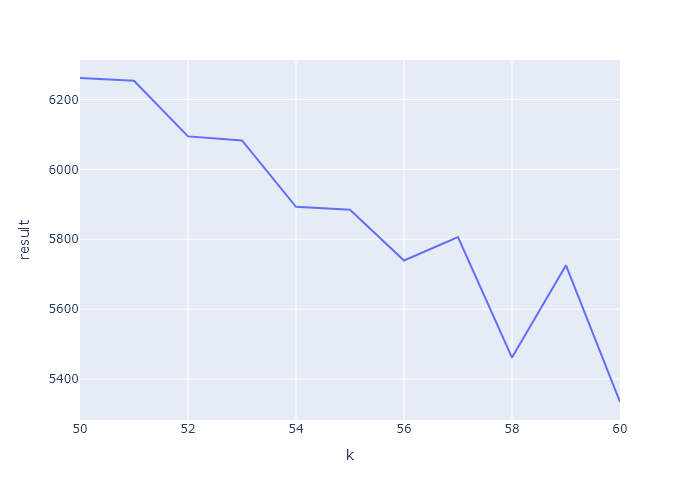

In [20]:
data_array = games_data_ml.to_numpy()
categorical_features_idx = list(range(1, games_data_ml.shape[1]))

result = {}
for k in range(50, 61):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, n_init = 15, init = 'Huang', random_state = SEED)
    kprototype.fit_predict(data_array, categorical=categorical_features_idx)
    labels = kprototype.labels_

    result[k] = calinski_harabasz_score(games_data_ml, labels)

df_kprototypes = pd.DataFrame(
    dict(
        k = result.keys(),
        result = result.values()
    )
)

fig = px.line(
    df_kprototypes, x='k', y='result'
)

fig.show("png")

Training and predicting data clusters

In [21]:
data_array = games_data_ml.to_numpy()
predict_data_array = predict_data.to_numpy()
categorical_features_idx = list(range(1, games_data_ml.shape[1]))

kprototype = KPrototypes(n_jobs = -1, n_clusters = 50, n_init = 15, init = 'Huang', random_state = SEED)
kprototype.fit(data_array, categorical=categorical_features_idx)

games_data['clusters'] = kprototype.predict(predict_data, categorical=categorical_features_idx)

In [22]:
games_data['clusters'].value_counts()

clusters
25    1981
41    1146
0      978
21     961
45     777
33     664
34     656
47     576
2      563
37     550
15     532
39     487
12     474
6      464
42     459
3      450
20     425
49     418
48     417
23     412
18     411
31     379
9      369
26     362
7      362
8      352
27     350
14     344
22     337
17     334
36     329
24     323
43     321
35     287
4      279
32     278
13     273
10     253
1      219
40     214
29     213
28     205
38     204
30     197
44     173
46     155
5      129
11     128
19     114
16     103
Name: count, dtype: int64

In [23]:
statistics_clusters(games_data[(games_data['clusters'] == 2)].reset_index())

single-player                       554
multiplayer                         110
co-operative                         36
massively-multiplayer-online-mmo      7
split-screen                          4
Name: count, dtype: int64

simulator                    503
strategy                     453
indie                        243
role-playing-rpg              66
turn-based-strategy-tbs       64
real-time-strategy-rts        61
puzzle                        46
tactical                      29
sport                         28
adventure                     27
racing                        20
arcade                        20
card-and-board-game           18
visual-novel                  15
shooter                       10
point-and-click                8
quiz-trivia                    4
platform                       4
music                          3
hack-and-slash-beat-em-up      1
fighting                       1
Name: count, dtype: int64

win                      484
mac                      232
linux                    161
ios                      124
ps4--1                   100
android                   96
switch                    82
xboxone                   74
steam-vr                  15
psvita                    14
oculus-rift               11
ps5                       11
psvr                      11
3ds                       10
browser                   10
series-x                  10
xbox360                    7
ps3                        7
stadia                     5
wiiu                       5
oculus-quest               4
meta-quest-2               4
winphone                   3
mobile                     3
windows-mixed-reality      2
oculus-vr                  2
psvr2                      1
palm-os                    1
new-nintendo-3ds           1
oculus-go                  1
Name: count, dtype: int64

science-fiction                              103
action                                       101
historical                                    98
business                                      82
sandbox                                       79
warfare                                       58
fantasy                                       50
educational                                   38
survival                                      31
kids                                          31
comedy                                        29
4x-explore-expand-exploit-and-exterminate     26
erotic                                        22
open-world                                    16
party                                         16
horror                                        13
non-fiction                                   10
romance                                       10
drama                                          8
stealth                                        7
mystery             

year_of_release
2016    174
2017     93
2018     92
2015     81
2014     77
2013     26
2019     16
2012      4
Name: count, dtype: int64

Creating a distance matrix with Jaccard to check the similar matches of each game

In [24]:
distance_matrix = pairwise_distances(predict_data[predict_data.columns[1:]].to_numpy(), metric='jaccard')

e:\Coding\Gaming Recommendation\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning:

Data was converted to boolean for metric jaccard



In [25]:
df_distances = pd.DataFrame(list(zip(games_data['id'],distance_matrix)), columns = ['id', 'distances'])

Create SQlite database for Streamlit

In [26]:
if os.path.exists('../Databases/streamlit_database.db'):
    os.remove('../Databases/streamlit_database.db')

In [27]:
df_distances_output = df_distances.copy()
df_distances_output['distances'] = df_distances_output['distances'].map(lambda x: ','.join(map(str, x)))
df_distances_output['distances'] = df_distances_output['distances'].map(lambda x: zlib.compress(bytes(x, 'utf-8')))

In [28]:
games_data_output = games_data.copy()
games_data_output['game_modes'] = games_data_output['game_modes'].map(lambda x: ','.join(map(str, x)))
games_data_output['genres'] = games_data_output['genres'].map(lambda x: ','.join(map(str, x)))
games_data_output['platforms'] = games_data_output['platforms'].map(lambda x: ','.join(map(str, x)))
games_data_output['themes'] = games_data_output['themes'].map(lambda x: ','.join(map(str, x)))

In [29]:
engine = create_engine('sqlite:///../Databases/streamlit_database.db', echo=False)

In [30]:
df_distances_output.to_sql(name='distances', con=engine, if_exists='append', index=False)
games_data_output.to_sql(name='game_data', con=engine, if_exists='append', index=False)

21387

In [31]:
engine.dispose()